# ECS7024 Statistics for Artificial Intelligence and Data Science - Coursework 2 Submission - Huy Quang Pham
## Texas Bridges Analysis - Outline and Table of Content

This Notebook details the process of analysing the conditions of Texas bridges based on the data and  instructions outlined in the coursework requirement. This analysis will consist of 3 parts:
1. Data Preparation (equivalent to Part 1 instructions)
    1. Import data and assign it to a dataframe variable
    1. Derive dependent variable and cleaning data set based on 3 rating variables 
    1. Derive independent variables and cleaning data set, specifically
        1. Derive Age and excluding old bridges
        1. Merging categories for Material and Design
        1. Removing outliers for Average daily traffic (AverageDaily) and Percentage of trucks (Trucks_percent)
1. Exploratory Analysis (equivalent to Part 2 instructions)
    1. Correlation/cross-tabulation among independent variables
    1. Univariate analysis between each independent variable and dependent variable
1. Regression Modelling (equivalent to Part 3 instructions)
    1. Final Variable Preparation
    1. Regression construction
    1. Regression results and recommendations


## 1: Data preparation (Calculating new variables)

Here is a step by step general overview of this part:
1. Import data and assign it to a dataframe variable
1. Derive dependent variable and cleaning data set based on 3 rating variables 
1. Derive independent variables and cleaning data set, specifically
    1. Derive Age and excluding old bridges
    1. Merging categories for Material and Design
    1. Removing outliers for Average daily traffic (AverageDaily) and Percentage of trucks (Trucks_percent)

In [1]:
# Importing a few packages that are expected to be used
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

### 1.1: Import data and assign it to a dataframe variable
The data set is imported from a csv file and datatype are assigned for each corresponding column. 

In [2]:
#create rating categories list for setting ratings as ordinal variables and reusability 
rating_categories = ['NA', 'Failed', 'Failing', 'Critical', 'Serious', 'Poor', 'Fair', 
                'Satisfactory', 'Good', 'Very Good', 'Excellent'] 

#Create ordered categories for rating variables
rating_type = pd.CategoricalDtype(
    categories=rating_categories, 
    ordered=True)

scour_type = pd.CategoricalDtype(
    categories=['Unknown', 'Critical','Unstable', 'Stable', 'Protected', 'Dry', 'No waterway'], 
    ordered=True)

#create a dictionary to specify datatype for each column
types_dict = { 'Structure_id': str, 'District':'category', 'Toll':'category', 
              'Maintainer':'category', 'Urban':'category', 'Status':'category', 'Year':'int64', 
              'Historic':'category', 'Service_under':'category', 'Material':'category', 
              'Design':'category', 
              'Deck_rating':rating_type, 'Superstr_rating':rating_type, 'Substr_rating':rating_type, 
              'Scour_rating':scour_type}

#import csv file in as bridges, with structure_id as index
bridges = pd.read_csv('tx19_bridges_sample.csv', dtype = types_dict, index_col = 'Structure_id')



### 1.2: Derive dependent variable and cleaning data set based on 3 rating variables
The data set general information is checked.

In [3]:
bridges.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34293 entries, 000021521-00101 to DAPTRABLI000011
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   District         34293 non-null  category
 1   Detour_Km        34293 non-null  int64   
 2   Toll             34293 non-null  category
 3   Maintainer       34293 non-null  category
 4   Urban            34293 non-null  category
 5   Status           34293 non-null  category
 6   Year             34293 non-null  int64   
 7   Lanes_on         34293 non-null  int64   
 8   Lanes_under      34293 non-null  int64   
 9   AverageDaily     34293 non-null  int64   
 10  Historic         34293 non-null  category
 11  Service_under    34293 non-null  category
 12  Material         34293 non-null  category
 13  Design           34293 non-null  category
 14  Spans            34293 non-null  int64   
 15  Length           34293 non-null  float64 
 16  Width            3429

Out of 24 columns, only 2 columns contain null data: Deck_rating and Superstr_rating. As both these columns will both be used to estimate a point representing a bridge's current condition, it will be impossible to correctly estimate a point for these bridge with missing data. This combined with the fact that there are a negligible number of bridges with missing data mean that these entries should, and will be dropped from the data set.

In [4]:
#get all rows with null Deck_rating / Superstr_rating
missing_rows = bridges.loc[(bridges.Deck_rating.isnull()) | (bridges.Superstr_rating.isnull()) ]

#drop the specified rows
bridges.drop(missing_rows.index, inplace=True)

#reprint data set's information
bridges.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34286 entries, 000021521-00101 to DAPTRABLI000011
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   District         34286 non-null  category
 1   Detour_Km        34286 non-null  int64   
 2   Toll             34286 non-null  category
 3   Maintainer       34286 non-null  category
 4   Urban            34286 non-null  category
 5   Status           34286 non-null  category
 6   Year             34286 non-null  int64   
 7   Lanes_on         34286 non-null  int64   
 8   Lanes_under      34286 non-null  int64   
 9   AverageDaily     34286 non-null  int64   
 10  Historic         34286 non-null  category
 11  Service_under    34286 non-null  category
 12  Material         34286 non-null  category
 13  Design           34286 non-null  category
 14  Spans            34286 non-null  int64   
 15  Length           34286 non-null  float64 
 16  Width            3428

Deck rating, Super structure rating and Sub structure rating will be used to calculate current condition point. A summary table is created to see the distribution of each rating.

In [5]:
Deck_rating = bridges.groupby(['Deck_rating']).size()
Superstr_rating = bridges.groupby(['Superstr_rating']).size()
Substr_rating = bridges.groupby(['Substr_rating']).size()

rating = {'Deck_rating': Deck_rating,
         'Superstr_rating': Superstr_rating,
         'Substr_rating': Substr_rating}
rating_count = pd.concat(rating,
                         axis = 1)
rating_count


,Deck_rating,Superstr_rating,Substr_rating
NA,0,0,0
Failed,12,16,16
Failing,5,3,4
Critical,1,4,20
Serious,2,22,59
Poor,82,139,364
Fair,1244,1366,2375
Satisfactory,7588,9089,10846
Good,21005,15518,17713
Very Good,4132,7774,2731


In all 3 aspects, there seem to be a high percentage of bridges considered good. The distribution between 3 ratings are quite similar. A clustered bar chart illustrate this uniformity.

<AxesSubplot:>

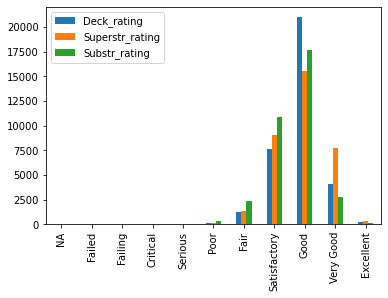

In [6]:
rating_count.plot(kind='bar')

In order to derive the current condition score for each bridge, it is neccessary to assign each bridge points corresponding to their 3 ratings. 

A scale of 0-9 with 0 as Failed and iterating 1 point for every level higher, to 9 as Excellent - highest is used (detailed scale are printed in the code below).

In [7]:
#assign all rating categories to corresponding points in a dict, using the list created above
rating_to_point = dict(zip(rating_categories, range(-1, 10)))    
print(rating_to_point)

# using dict to map Rating to point for each component
bridges['Deck_point'] = bridges['Deck_rating'].map(rating_to_point)
bridges['Superstr_point'] = bridges['Superstr_rating'].map(rating_to_point)
bridges['Substr_point'] = bridges['Substr_rating'].map(rating_to_point)

#rechecking
#bridges[['Deck_rating','Deck_point']].drop_duplicates().sort_values(by='Deck_rating')
#bridges[['Superstr_rating','Superstr_point']].drop_duplicates().sort_values(by='Superstr_rating')
#bridges[['Substr_rating','Substr_point']].drop_duplicates().sort_values(by='Substr_rating')
#bridges['Deck_point1'] = bridges['Deck_rating'].map(rating_to_point)

# adding all 3 points for the final condition point
bridges['Rating_point'] = bridges.loc[:, "Deck_point":"Substr_point"].sum(axis=1)

bridges.groupby(['Rating_point']).size()

{'NA': -1, 'Failed': 0, 'Failing': 1, 'Critical': 2, 'Serious': 3, 'Poor': 4, 'Fair': 5, 'Satisfactory': 6, 'Good': 7, 'Very Good': 8, 'Excellent': 9}


Rating_point
0.0       12
1.0        2
3.0        2
5.0        2
7.0        1
9.0        1
10.0       2
11.0       3
12.0      12
13.0      38
14.0      91
15.0     311
16.0     669
17.0    1531
18.0    3492
19.0    4458
20.0    6039
21.0    8787
22.0    5301
23.0    2212
24.0    1036
25.0      96
26.0      84
27.0     104
dtype: int64

A histogram of all current condition points is plotted. The distribution is quite symetrical (normal), albeit with a left tail. 

This mean it is a suitable dependent variable. 

The most common point is 21, which is equivalent to all 3 "Good" ratings. 

<AxesSubplot:ylabel='Frequency'>

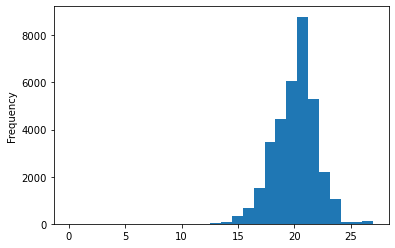

In [8]:
#Plot a histogram from current condition points (Rating_point)
#Divided into 28 bins because the lowest score is 0 and highest is 27
bridges['Rating_point'].plot(kind='hist', bins=28)

### 1.3: Derive independent variables and cleaning data set

#### Age
Age is derived from Year. A histogram is plotted for Age for further analysis.

<AxesSubplot:>

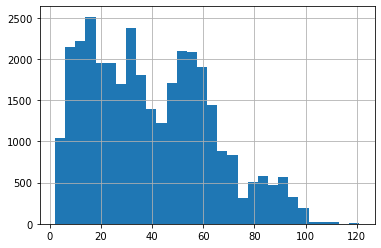

In [9]:
#calculating Age
bridges['Age'] = 2021 - bridges["Year"]
#histogram
bridges['Age'].hist(bins=30)

It seems like the Age variable has a multimodal distribution with a right tail. As per instruction to exclude very old bridges, an outlier threshold needs to be established. 

Following the boxplot's definition of outlier, a threshold of 93 is provided. 

In [10]:
#reusable IQR outlier function
def iqr_positive_outlier(column_name):
    q3 = bridges[column_name].quantile(q=0.75)
    q1 = bridges[column_name].quantile(q=0.25)
    median = bridges[column_name].median()
    outlier = median+1.5*(q3-q1)
    return outlier
def iqr_negative_outlier(column_name):
    q3 = bridges[column_name].quantile(q=0.75)
    q1 = bridges[column_name].quantile(q=0.25)
    median = bridges[column_name].median()
    outlier = median-1.5*(q3-q1)
    return outlier

iqr_positive_outlier('Age')

93.0

However, it is better to have a closer look at bridges' Age and Historic status, as in my opinion, old registered historic bridges might have special treatment and care, and thus will not be beneficial to keep in for this analysis.

In [11]:
#create age bins for easier representation with Historic status
age_bin_separator = list(range(0,110,10))
age_bin_separator.append(math.inf)

age_bins = [f"{str(x)}-{str(x+10)}" for x in range(0,100,10)]
age_bins.append('100+')

bridges['Age group'] = pd.cut(bridges['Age'],
                              bins=age_bin_separator, #dividing into 11 categories
                              labels=age_bins,
                              include_lowest=True)

#a = bridges.loc[bridges.Historic == 'Register']
bridges.pivot_table(index = 'Historic', columns = 'Age group', values = 'Age', aggfunc = 'count')
#bridges['Age'].quantile(q=0.9)

#bridges[['Age','Age group']].describe()

#ax = sns.boxplot(x='Historic', y="Age", data=bridges)

Age group,0-10,10-20,20-30,30-40,40-50,50-60,60-70,70-80,80-90,90-100,100+
Historic,,,,,,,,,,,
Not historic,3608,5703,4643,4630,1283,6,16,12,5,2,0
Possible,22,1,1,0,2611,4956,2915,1160,1327,827,83
Register,6,0,3,1,3,11,68,48,145,81,51
Unknown,38,1,2,0,8,7,2,0,0,0,0


As seen from the cross-tab table above, older bridges fall mostly in registered historic bridges or possible historic bridges. As mentioned above, due to the potential special treatment historic bridges may receive, it is wise to exclude more older historic bridges. For registered historic bridges, omes older than 80 years old will be dropped. Non-historic bridges over 100 will also be dropped, as those seem to be outliers in this data set.

It is worth noting a few new bridges are classified as Historic, and while that might be an error, there is no way to verify that, therefore those will stay as is.

In [12]:
#get index of rows to drop
Age_outlier = bridges.loc[((bridges['Historic'] == 'Register') & (bridges['Age'] > 80)) | 
                          ((bridges['Historic'] == 'Possible') & (bridges['Age'] > 100))]
bridges.drop(Age_outlier.index, inplace=True)
bridges.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33926 entries, 000021521-00101 to DAPTRABLI000011
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   District         33926 non-null  category
 1   Detour_Km        33926 non-null  int64   
 2   Toll             33926 non-null  category
 3   Maintainer       33926 non-null  category
 4   Urban            33926 non-null  category
 5   Status           33926 non-null  category
 6   Year             33926 non-null  int64   
 7   Lanes_on         33926 non-null  int64   
 8   Lanes_under      33926 non-null  int64   
 9   AverageDaily     33926 non-null  int64   
 10  Historic         33926 non-null  category
 11  Service_under    33926 non-null  category
 12  Material         33926 non-null  category
 13  Design           33926 non-null  category
 14  Spans            33926 non-null  int64   
 15  Length           33926 non-null  float64 
 16  Width            3392

#### Material and design
Merging categories

##### Material
A summary of the number of bridges with different types of material is detailed below.

           Year
Material       
Concrete  26938
Masonry       7
Other        48
Steel      6469
Timber      464


<AxesSubplot:xlabel='Material'>

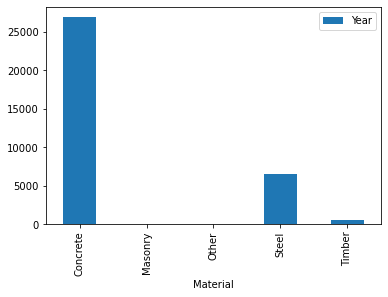

In [13]:
material = bridges.pivot_table(values='Year', index='Material', aggfunc='count')
print(material)
material.plot(kind='bar')

Concrete and steel are the 2 most popular materials used, while timber, mansory, and others are used much less, therefore for ease of analysis, both timber and mansory will be classed as 'Other'.

In [14]:
#Set up a dictionary with values as new categories for mapping 
material_mapping = {'Concrete': 'Concrete', 
                    'Masonry': 'Other',  # set Masonry as Other
                    'Other': 'Other', 
                    'Steel': 'Steel', 
                    'Timber': 'Other'}   # set Timber as Other

bridges['Material'] = bridges['Material'].map(material_mapping)

bridges.pivot_table(values='Year', index='Material', aggfunc='count')

,Year
Material,
Concrete,26938
Other,519
Steel,6469


##### Design
A summary of the number of bridges with different types of material is detailed below.

             Year
Design           
Arch          117
Beam        28198
Frame          65
Movable        12
Other        1236
Slab         4259
Suspension      3
Truss          36


<AxesSubplot:xlabel='Design'>

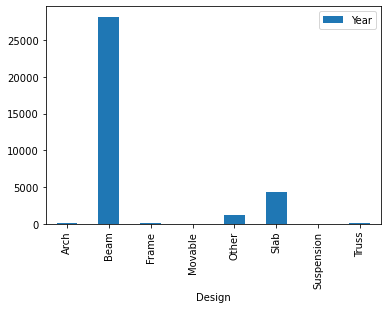

In [15]:
design = bridges.pivot_table(values='Year', index='Design', aggfunc='count')
print(design)
design.plot(kind='bar')

Beam and Slab are the 2 most popular designs used, while there are a lot of other more obscure designs, therefore for ease of analysis, all designs other than Beam and Slab will be classed as 'Other'.

In [16]:
design_mapping = {'Arch': 'Other', 
                    'Beam': 'Beam', 
                    'Frame': 'Other', 
                    'Movable': 'Other', 
                    'Other': 'Other', 
                    'Slab': 'Slab', 
                    'Suspension': 'Other', 
                    'Truss': 'Other'}   # set Timber as Other

bridges['Design'] = bridges['Design'].map(design_mapping)

bridges.pivot_table(values='Year', index='Design', aggfunc='count')

,Year
Design,
Beam,28198
Other,1469
Slab,4259


#### Truck percent and Average Use

##### Truck Percentage
An overview of the distribution of truck traffic percentage is provided below. The majority of bridges have a truck percentage close to 0, while only a handful has over 70% traffic as trucks. All values lies within a logical range, so no treatment is needed. 

<AxesSubplot:>

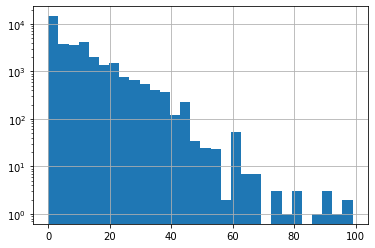

In [17]:
bridges['Trucks_percent'].hist(bins=30, log=True)

##### AverageDaily
An overview of the distribution of average daily traffic is provided below. The majority of bridges have daily traffic close to 0, while there are some that are unusually higher compared to the rest. Because these values are unusually high, they are considered outliers and the corresponding bridges will be removed from the data set. 

<AxesSubplot:>

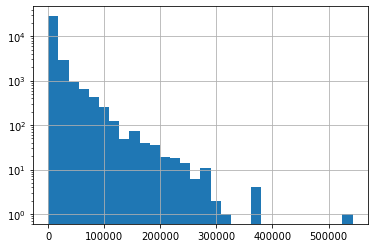

In [18]:
bridges['AverageDaily'].hist(bins=30, log=True)

<AxesSubplot:>

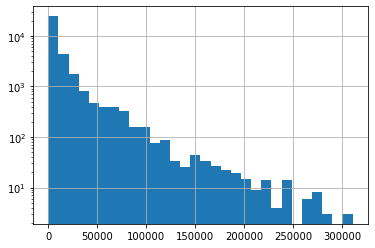

In [19]:
#removing AverageDaily higher than 350000
OutlierAvgDaily = bridges.loc[(bridges['AverageDaily']>350000)]
bridges.drop(OutlierAvgDaily.index, inplace=True)
bridges['AverageDaily'].hist(bins=30, log=True)

Finally, a new Data Frame is created with the current condition point and 5 independent variables.

In [20]:
short_list = bridges.loc[:, 
                         ['Rating_point', 'Age', 
                          'Material', 'Design', 
                          'AverageDaily', 'Trucks_percent']]

## 1: Explanatory Analysis 

Here is a step by step general overview of this part:
1. Correlation/cross-tabulation between independent variables
    1. Correlation among continuous variables
    1. Cross-tabulation among discrete variables
    1. Box-plot by category between a continuous and a discrete variable
1. Univariate analysis for each independent variable

### Correlation/cross-tabulation between independent variables
#### Correlation among continuous variables
A correlation matrix with a heatmap is plotted below. Among the 3 independent continuous variables, only Age and Truck_percent seem to have any noticable correlation, while AverageDaily have little correlation to both. 

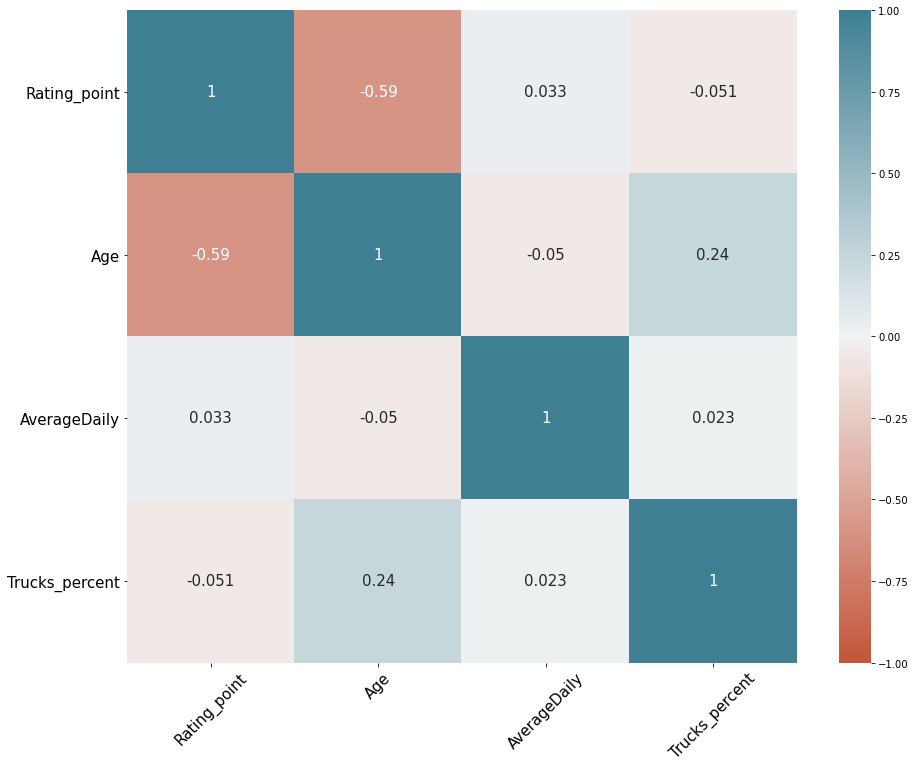

In [21]:
fig,ax = plt.subplots(1,1, figsize=(15,12))
sns.heatmap(short_list.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True), 
            annot=True, ax=ax, annot_kws={"size": 15})
_y = plt.yticks(rotation=0, fontsize=15)
_x = plt.xticks(rotation=45, fontsize=15)

A scatter matrix is not helping to show clearly the relationships, due to high number of observations with 0 Truck_percent and AverageDaily.

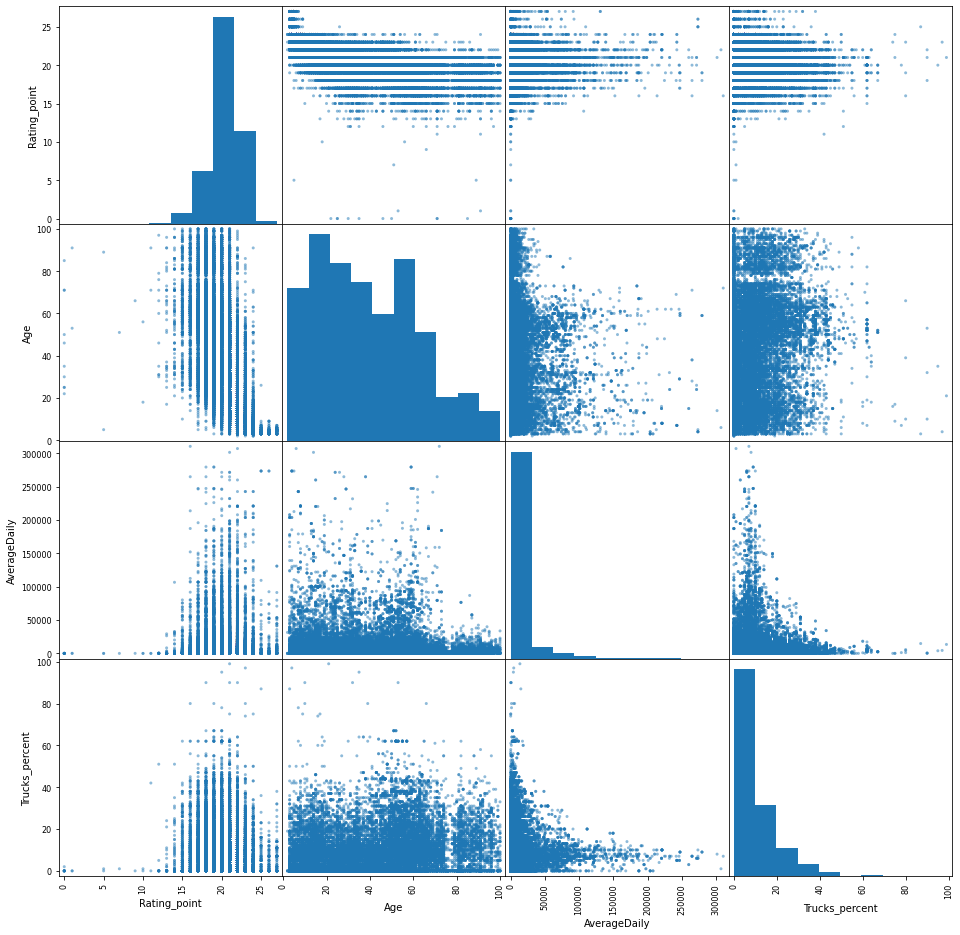

In [22]:
_a = pd.plotting.scatter_matrix(short_list, figsize=(16,16))

By looking at a detailed scatter plot with higher Truck percentage removed, it can be seen that there is a positive correlation, particularly among bridges between the age of 0 to 60, which sees older bridges have higher percentage of truck traffic. This could be due to a regulation or historical plan to construct multiple bridges specifically for trucks in the same period, and reducing that focus in the following years. However, this level of correlation between 2 variables is considered acceptable for use in regression analysis.

<AxesSubplot:xlabel='Age', ylabel='Trucks_percent'>

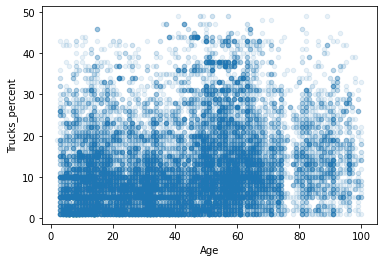

In [23]:
short_list.loc[(short_list['Trucks_percent']<50) & (short_list['Trucks_percent']>0)].plot(kind='scatter',  x='Age', y='Trucks_percent',  alpha=0.1, sharex=False)

#### Cross-tabulation between discrete variables
A cross-tabulation between Material and Design is detailed below. This focuses on the influence design have on the material chosen for each bridge.

Text(0.5, 1.0, 'Material given Design')

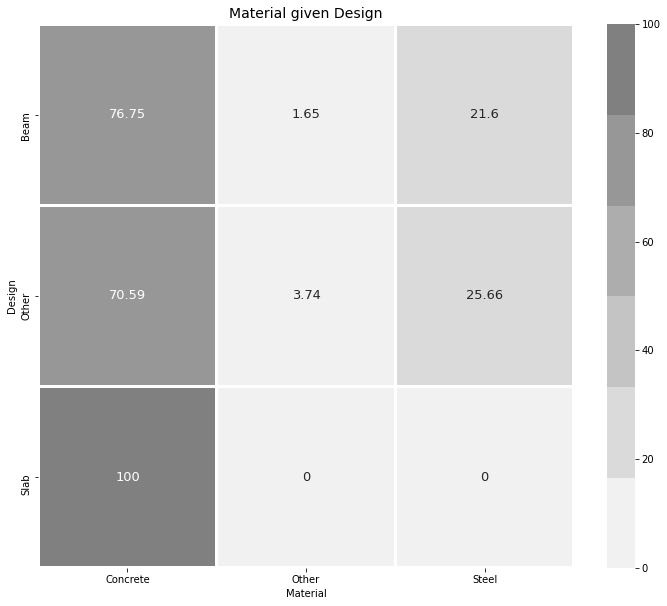

In [24]:
mat_design = pd.crosstab(short_list['Design'], short_list['Material'], normalize='index').round(4) * 100

fig,ax = plt.subplots(1,1, figsize=(12,10))
sns.heatmap(mat_design, cmap=sns.light_palette('grey'), linewidths = 2,
            annot=True, ax=ax, annot_kws={"size": 13}, fmt='g')
ax.set_title('Material given Design', fontsize=14)

#### Categorical box-plot for continuous variable
This looks at the distribution of continuous independent variables given the different categories of Design / Material.

Age will be considered first.

Text(0, 0.5, 'Age')

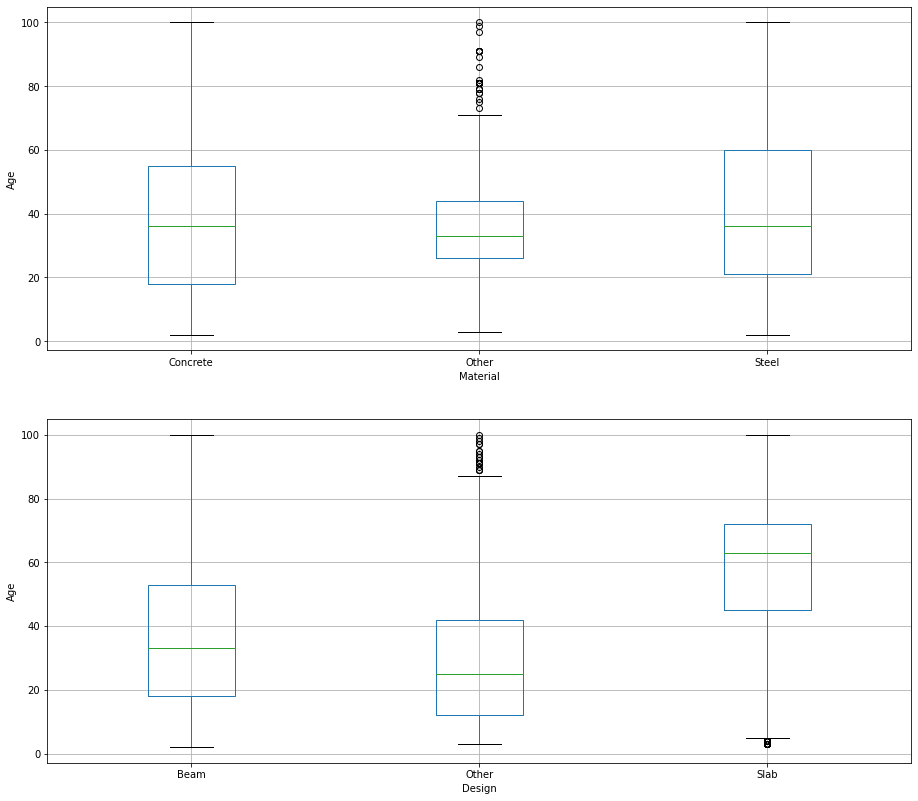

In [25]:
fig, (a1, a2) = plt.subplots(2,1, figsize=(15,14))

bridges.boxplot(column='Age', by='Material', ax=a1)
bridges.boxplot(column='Age', by='Design', ax=a2)

# Make the plots a bit clearer
fig.suptitle('')
[a.set_title('') for a in [a1, a2]]
a1.set_ylabel('Age')
a2.set_ylabel('Age')


Looking at Material, Concrete and Steel - the 2 most popular materials have been used alternatively for building bridges for a long time, as they are present in both older bridges and newer bridges. Other materials seem to be a newer choice as these bridges have lower ages compared to the other two materials.

Looking at Design, it seems like even though Slab designs are still prevalent, the high ages of current bridges with a Slab design meant they might no longer be a popular choice. Other designs have a younger age profile, meaning among those might have a new design to take over the slab design.

Daily Average Traffic will now be considered. As the data for Daily Average Traffic is heavily skewed, its logarithm will be used for visualization.

C:\for_work\anaconda\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'AverageDailyLog')

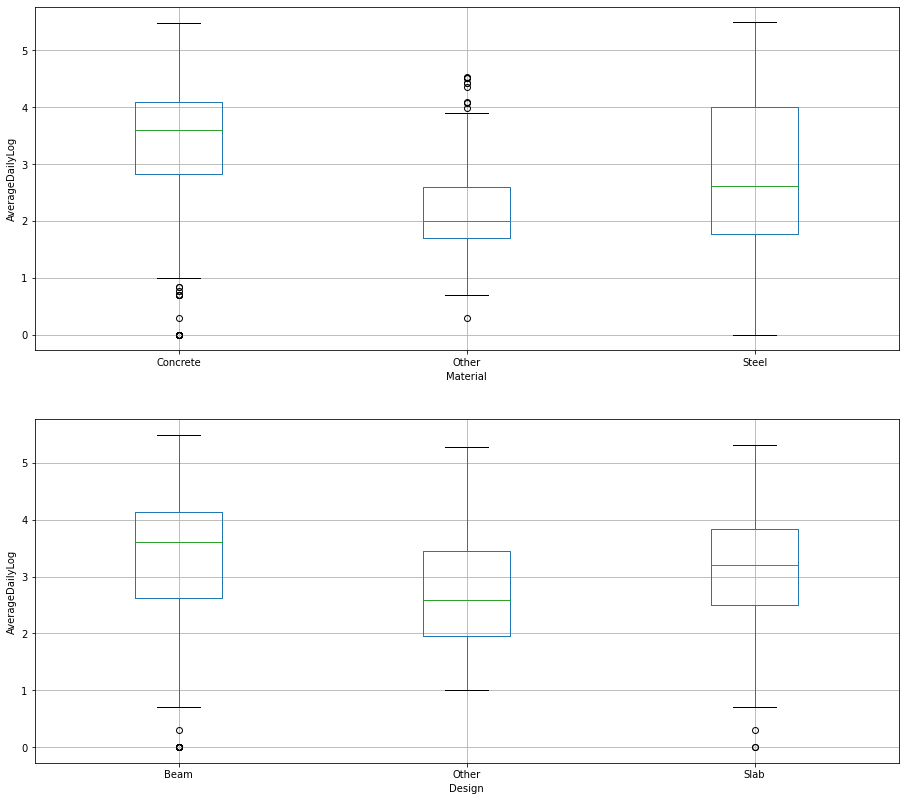

In [26]:
#create new df with log of average daily 
brd_logs = short_list.assign(AverageDailyLog = np.log10(bridges.AverageDaily))

fig, (a1, a2) = plt.subplots(2,1, figsize=(15,14))

brd_logs.boxplot(column='AverageDailyLog', by='Material', ax=a1)
brd_logs.boxplot(column='AverageDailyLog', by='Design', ax=a2)

# Make the plots a bit clearer
fig.suptitle('')
[a.set_title('') for a in [a1, a2]]
a1.set_ylabel('AverageDailyLog')
a2.set_ylabel('AverageDailyLog')


Concrete bridges get more daily traffic compared to other bridges. Steel bridges have highly varying degree of usage. When it comes to the design of the bridges, Beam bridges seem to be the most busy on average, followed by Stab bridges.

### Univariate Analysis
Correlations / Box-plot between each independent variable and the dependent variable.

#### Correlation
According to the correlation matrix, among the continuous variables, Age is the only one with a significant correlation with current condition point, with a clear negative trend, meaning the older a bridge, the lower score it gets. There are no clear trend for both AverageDaily and Truckspercent, meaning those variables may not be a great indicator of the condition of the bridges.

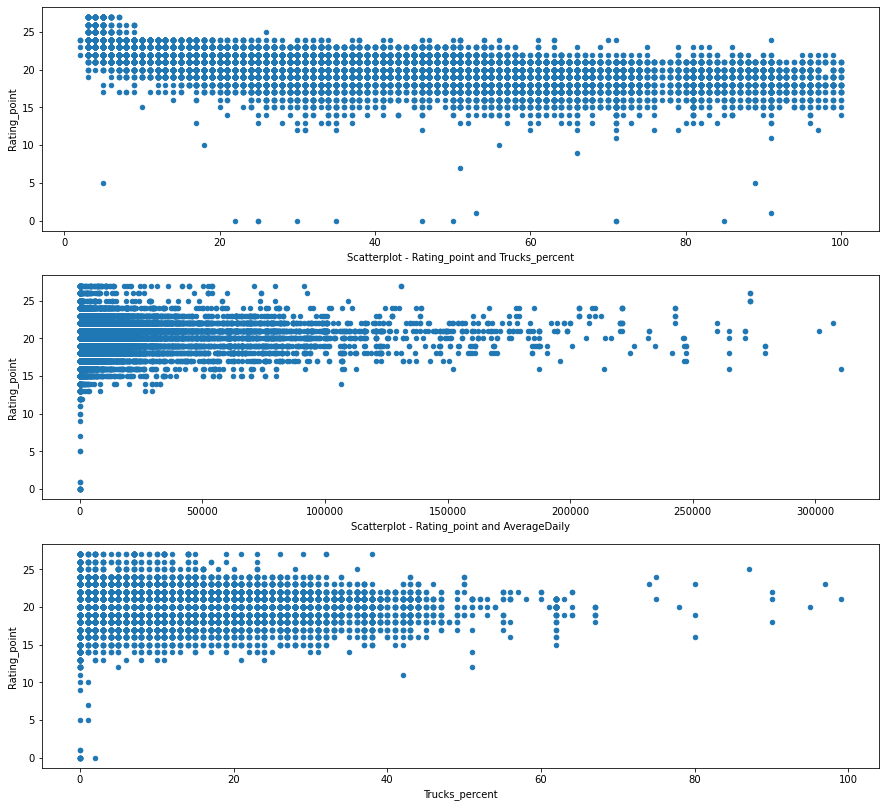

In [27]:
fig, (a1,a2,a3) = plt.subplots(3, 1, figsize=(15,14))

short_list.plot(kind='scatter',  x='Age', y='Rating_point', ax=a1)
short_list.plot(kind='scatter',  x='AverageDaily', y='Rating_point', ax=a2)
short_list.plot(kind='scatter',  x='Trucks_percent', y='Rating_point', ax=a3)

_ = a1.set_xlabel('Scatterplot - Rating_point and Age')
_ = a2.set_xlabel('Scatterplot - Rating_point and AverageDaily')
_ = a1.set_xlabel('Scatterplot - Rating_point and Trucks_percent')

#### Categorical Box-plot
The following boxplot represents the distribution of current condition points for each design and material used.

Design-wise, Stab seem to have the lowest average score compared to Beam and Other design. However, this might be because Stab designs are generally older bridges, which as discussed had lower scores.

Material-wise, concrete bridges seem to have superior current condition scores. Steel in general have a slightly higher score than the bunch of other materials.

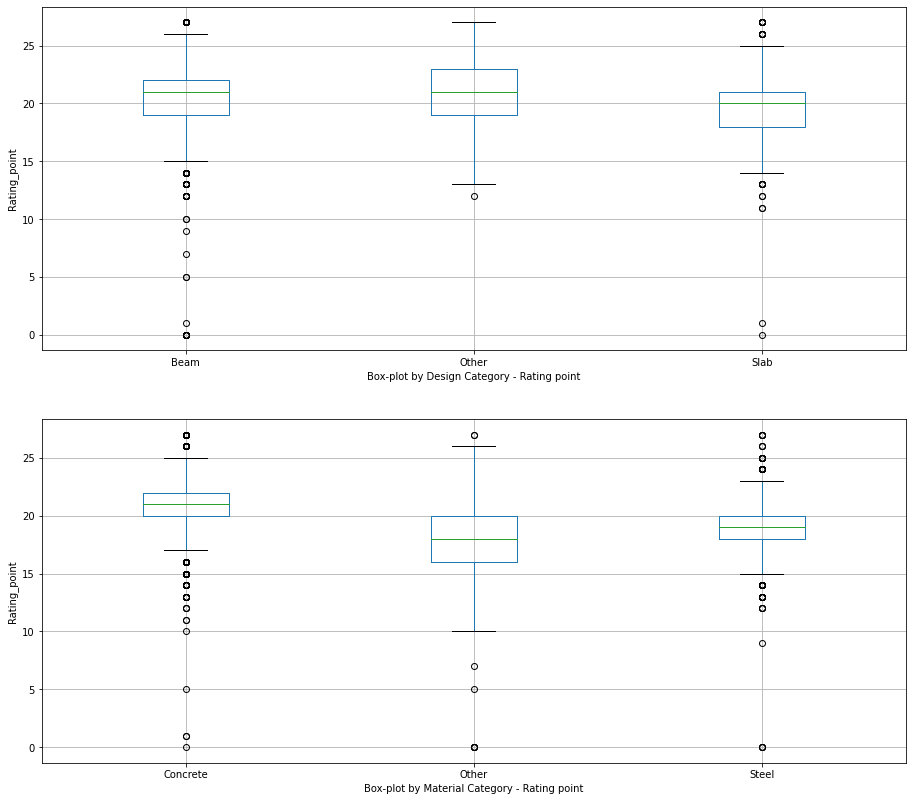

In [28]:
fig, (a1, a2) = plt.subplots(2,1, figsize=(15,14))

short_list.boxplot(column='Rating_point', by='Design', ax=a1)
short_list.boxplot(column='Rating_point', by='Material', ax=a2)

# Make the plots a bit clearer
fig.suptitle('')
[a.set_title('') for a in [a1, a2]]
a1.set_ylabel('Rating_point')
a2.set_ylabel('Rating_point')
_ = a1.set_xlabel('Box-plot by Design Category - Rating point')
_ = a2.set_xlabel('Box-plot by Material Category - Rating point')

### Regression
Here is a step by step general overview of this part:
1. Final Variable Preparation
1. Regression construction
1. Regression results and conclusions

#### Final Variable Preparation
Transform 2 categorical variables to be suitable for regression

In [1]:
jupyter notebook list

SyntaxError: invalid syntax (<ipython-input-1-46cbd787b5a9>, line 1)

In [29]:
short_list_dummies = pd.get_dummies(short_list.loc[:, ['Material', 'Design']], drop_first=False)
short_list_dummies

,Material_Concrete,Material_Other,Material_Steel,Design_Beam,Design_Other,Design_Slab
Structure_id,,,,,,
000021521-00101,1,0,0,0,0,1
000021521-00181,1,0,0,0,0,1
000021521-TMP20,1,0,0,1,0,0
000021525-00012,0,1,0,1,0,0
000021580-00092,1,0,0,1,0,0
...,...,...,...,...,...,...
DAPFORHOO000012,1,0,0,1,0,0
DAPFORHOO000013,1,0,0,1,0,0
DAPFORHOO000015,1,0,0,1,0,0


#### Fit variables into regression 

In [30]:
y = short_list.Rating_point 
#put all independent variables in X 
X = np.column_stack((short_list.Age, short_list.AverageDaily, 
                      short_list.Trucks_percent, short_list_dummies.Material_Concrete, 
                      short_list_dummies.Material_Steel, short_list_dummies.Design_Beam, 
                      short_list_dummies.Design_Slab))
#Omitting Material_Other and Design_Other variables due to the nature of dummy variables.
#fit X and y in a Linear regression model
reg = LinearRegression().fit(X, y)

#### Regression Results and Recommendation

In [33]:
#set variables to get Betas
b_Age, b_AvgDaily, b_Truck_perc, b_mat_concrete, b_mat_steel, b_des_beam, b_des_stab = reg.coef_
print('The R2 coefficient of determination is %4.3f' % reg.score(X, y))
print('The intercept is %4.1f' % reg.intercept_)
print('The regression coefficient for Age is %4.2f'% b_Age)
print('The regression coefficient for AverageDaily is %4.10f'% b_AvgDaily)
print('The regression coefficient for Trucks_percent is %4.4f'% b_Truck_perc)
print('The regression coefficient for Material_concrete is %4.2f'% b_mat_concrete)
print('The regression coefficient for Material_steel is %4.2f'% b_mat_steel)
print('The regression coefficient for Design_Beam is %4.2f'% b_des_beam)
print('The regression coefficient for Design_Stab is %4.2f'% b_des_stab)

The R2 coefficient of determination is 0.449
The intercept is 19.8
The regression coefficient for Age is -0.05
The regression coefficient for AverageDaily is -0.0000007528
The regression coefficient for Trucks_percent is 0.0057
The regression coefficient for Material_concrete is 2.84
The regression coefficient for Material_steel is 1.47
The regression coefficient for Design_Beam is -0.11
The regression coefficient for Design_Stab is -0.18


##### Model fit and coefficients
The model fitted has an R-squared - coefficient of determination, which represents the proportion of variance of the dependent variable that is explained by the variance of the independent variables - of **44.9%**. This means almost half of the changes in Rating point (current condition point) can be predicted from a change in the independent variables.

According to the model, a 0-year-old bridge that is built with Other Design and Other Material, has no Daily traffic and 0 percent Trucks going through will have a score of **19.8**. 

Holding all other variables constant, if a bridge is made of Steel or Concrete rather than Other Materials, the current condition point will increase by **1.47** and **2.84**, respectively.

However, changing the design from Other to Beam or Stab designs would both decrease the Rating point by **0.11** and **0.18**, holding all other variables constant.

As with Age, holding all other variables constant, if that bridge's age increases by *10*, the score will drop by **0.5**.

Average Daily traffic and percentage of Trucks in traffic have minimal impact on the changes of Rating point. An increase of 1 million car in traffic per day would see the score decrease only by **0.75** (meanwhile the maximum recorded Average daily traffic is just over 500 thousand). A 10% increase of percentage of Trucks in traffic would actually see an increase in points by **0.057**, but again this is very minimal.

##### Residual distribution
Linear Regression assumes normal distribution of the residual (errors between the observed value and predicted value of the dependent variable).

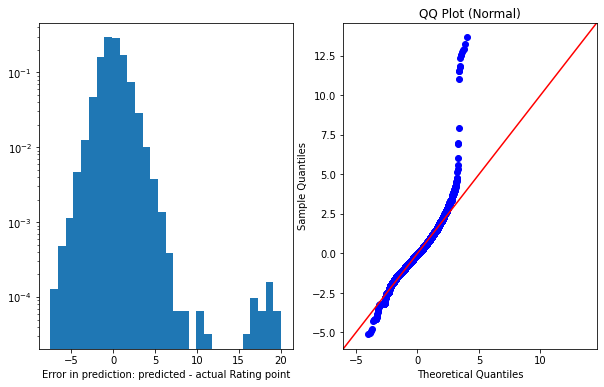

In [32]:
y_hat = reg.predict(X)
residuals = y_hat - y

fig, (a1, a2) = plt.subplots(1, 2, figsize=(10,6))

a1.hist(residuals, bins=30, density=True, log=True)
_ = a1.set_xlabel('Error in prediction: predicted - actual Rating point')

f = sm.qqplot(residuals, fit=True, line='45', ax=a2)
_ = a2.set_title('QQ Plot (Normal)')

The distribution of the residuals is positively skewed, which means at the current state it is likely not a good estimator for the rating points.

##### Conclusion and Recommendation:
Given the 5 variables agreed upon, the linear regression model was a decent estimator. However, there were still issues with normality of residuals and the inclusion of low-magnitude explanatory variables (Average daily traffic, Trucks percentage). There were also questions regarding the accuracy of data (Historic status etc.)

There are a few potential improvements with data input, for example in data collection, there is a need for more relevant data e.g. last refurbishment, daily average load etc. and assurance (accuracy); as well as with the processing and the models, such as trying fitting the logarithmic / quadratic form of a few variables, as well as using a more robust regression.